In [31]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Flatten, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

In [32]:
# 1. Load and Prepare the Dataset
def load_dataset():
    def scale_images(data):
        image = data['image']
        return tf.cast(image, tf.float32) / 255.0 

    ds = tfds.load('fashion_mnist', split='train[:10%]')
    ds = ds.map(scale_images)
    ds = ds.cache()
    ds = ds.shuffle(60000)
    ds = ds.batch(128)
    ds = ds.prefetch(64)
    return ds


In [33]:
# 2. Build the Generator
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    return model

In [34]:
# 3. Build the Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [35]:
# 4. Callback to Monitor Progress
class ModelMonitor(Callback):
    def __init__(self, generator, num_img=3, latent_dim=128):
        self.generator = generator
        self.num_img = num_img
        self.latent_dim = latent_dim
        os.makedirs('images', exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        generated_images *= 255
        generated_images = generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [36]:


# 5. GAN Training Model
class FashionGAN(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss):
        super().compile()
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        batch_size = tf.shape(batch)[0]
        real_images = batch
        fake_images = self.generator(tf.random.normal((batch_size, 128)), training=False)

        # Discriminator training
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            y_realfake = tf.concat([
                tf.zeros_like(yhat_real),  # Real = 0
                tf.ones_like(yhat_fake)    # Fake = 1
            ], axis=0)
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((batch_size, 128)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [37]:
# 6. Train the Model
def train():
    ds = load_dataset()
    generator = build_generator()
    discriminator = build_discriminator()
    gan = FashionGAN(generator, discriminator)
    gan.compile(
        g_opt=Adam(1e-4),
        d_opt=Adam(1e-5),
        g_loss=BinaryCrossentropy(),
        d_loss=BinaryCrossentropy()
    )
    monitor = ModelMonitor(generator, num_img=4)
    history = gan.fit(ds, epochs=5, callbacks=[monitor])
    return history, generator, discriminator

In [38]:
# Train and save models
history, generator, discriminator = train()
generator.save('generator.h5')
discriminator.save('discriminator.h5')

Epoch 1/5
47/47 [==============================] - 600s 13s/step - d_loss: 0.6872 - g_loss: 0.7224
Epoch 2/5
47/47 [==============================] - 623s 13s/step - d_loss: 0.5285 - g_loss: 0.6937
Epoch 3/5
47/47 [==============================] - 610s 13s/step - d_loss: 0.4946 - g_loss: 0.6978
Epoch 4/5
47/47 [==============================] - 587s 12s/step - d_loss: 0.4919 - g_loss: 0.7048
Epoch 5/5
47/47 [==============================] - 593s 13s/step - d_loss: 0.4847 - g_loss: 0.7177


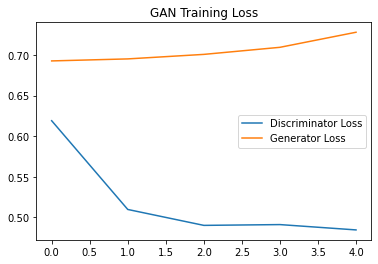

In [40]:
# Plot Loss
plt.plot(history.history['d_loss'], label='Discriminator Loss')
plt.plot(history.history['g_loss'], label='Generator Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.savefig("loss_plot.png")
plt.show()